<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/BT_MNIST_new3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Install
!pip install self_supervised

!pip install pytest
!pip install ipytest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 170.2 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 989.4 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typi

In [3]:
#import 
import fastai
import self_supervised
import torch
if torch.cuda.is_available():device='cuda'
else:device='cpu'
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
from torchvision import transforms
import inspect
import warnings
import random
import math
warnings.filterwarnings("ignore")
import ipytest
ipytest.autoconfig()
import pytest

In [27]:
#Base functions / classes we need to train a BT / RBT model.
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):self.encoder,self.projector = encoder,projector
        
    def forward(self,x): 
        
        return self.projector(self.encoder(x))

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 

#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(n=2,size=size,**kwargs)

def random_sinusoid(x,std=0.1,seed=0):
    
    seed_everything(seed=seed)    
    t=(std) * torch.randn(1,500).to(device)
    s=(std) * torch.randn(1,500).to(device)
    
    u=torch.randn(1,500).to(device)
    v=torch.randn(1,500).to(device)

    a=(0.2) * torch.randn(1,500).to(device)
    b=(0.2) * torch.randn(1,500).to(device)

    return a*torch.sin(t*x[:,]*math.pi+u) + b*torch.cos(s*x[:,]*math.pi+v)

def C_z1z2(z1norm,z1norm_2,z2norm,z2norm_2,bs,indep=True):
    
    if indep == False:
        Ctem1 =  (z1norm.T @ z2norm_2) / bs
        Ctem2 = (z1norm_2.T @ z2norm) / bs
        cdiff_2 = (0.5*Ctem1.pow(2) + 0.5*Ctem2.pow(2))
        
    elif indep == True:
        cdiff_2 =  (z1norm_2.T @ z2norm_2) / bs
        

    return cdiff_2


class Cdiff_Rand:
    
    def __init__(self,seed,bs,std=0.1,K=2):
        self.seed=seed
        self.std=std
        self.K=K
        self.bs=bs

    def __call__(self,z1norm,z2norm):
        
        cdiff_rand=0
        for i in range(self.K):

            z1norm_2,z2norm_2 = random_sinusoid(z1norm,std=self.std,seed=self.seed+i), random_sinusoid(z2norm,std=self.std,seed=2*self.seed+i)
            cdiff_rand = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,bs=bs)

        cdiff_rand=(1/self.K)*cdiff_rand
    
        return cdiff_rand

class Max_Corr(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(ps,ps)
        self.fc2 = nn.Linear(ps,ps)

        self.fc3 = nn.Linear(ps,ps)
        self.fc4 = nn.Linear(ps,ps)

        self.sigmoid = nn.Sigmoid()

        self.relu = nn.ReLU()
    def forward(self,x,y):

        x=self.sigmoid(self.fc1(x)) #when (sigmoid,relu) GREAT results, with (sigmoid,sigmoid) TERRIBLE. Currently testing (relu,relu)
        x=self.fc2(x)
       
        y=self.relu(self.fc3(y)) #originally had relu and got really good results. If we can't reproduce those results, possible reasons:
                                    #results were due to chance; or having relu on one branch (and sigmoid on the other) helps via breaking
                                      #the symmetry! Other idea: set fc1=fc3, fc2=fc4. 
        y=self.fc4(y)

        return x,y

class Cdiff_Sup:
    
    def __init__(self,I,inner_steps,bs):
        
        self.I=I
        self.inner_steps=inner_steps
        self.bs=bs
        self.max_corr = Max_Corr()
        if device == 'cuda':
            self.max_corr.cuda()
        
    def inner_step(self,z1norm,z2norm):
    
        max_corr=self.max_corr
        I=self.I
        bs=self.bs
        inner_steps=self.inner_steps

        z1norm=z1norm.detach()
        z2norm=z2norm.detach()

        # z1norm=z1norm[:,0]
        # z2norm=z2norm[:,0]

        max_corr = Max_Corr()
        max_corr.cuda()
    
        # for p in max_corr.parameters():
        #     p.requires_grad=True]

        optimizer = torch.optim.Adam(list(max_corr.parameters()),lr=0.001)
        for i in range(inner_steps):
            z1norm_2,z2norm_2=max_corr(z1norm,z2norm)
            #z1norm_2 = (z1norm_2 - z1norm_2.mean(0)) / z1norm_2.std(0, unbiased=False)
        
            assert (z1norm_2.shape,z2norm_2.shape) == (z1norm.shape,z2norm.shape)

            # Ctem1 =  (z1norm.T @ z2norm_2) / bs
            # Ctem2 = (z1norm_2.T @ z2norm) / bs
            # cdiff_2 = (0.5*Ctem1.pow(2) + 0.5*Ctem2.pow(2))

            cdiff_2 = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,bs=bs,indep=False)
            #cdiff_2=Ctem.pow(2)

            inner_loss=-1*(cdiff_2*(1-I)).mean()

            optimizer.zero_grad()
            inner_loss.backward()
            optimizer.step()
        
        for p in max_corr.parameters():
            p.requires_grad=False
            
        return max_corr
    
    def __call__(self,z1norm,z2norm):
        
            max_corr =  self.inner_step(z1norm,z2norm)
            z1norm_2,z2norm_2 = max_corr(z1norm,z2norm)
      
            cdiff_sup = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,bs=bs,indep=False)
    
            return cdiff_sup


#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        self.index=-1

        self.inner_steps=4
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def update_seed(self):
        
        indexmod=2
        if self.index%indexmod == 0: #every `indexmod` index update the seed (best we have found so far)
            self.seed = np.random.randint(0,10000)

    def before_epoch(self):
        self.index=-1

        if self.epoch%10==0:
            self.inner_steps += 1
            
    def before_batch(self):
    
        xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))
        self.learn.xb = (torch.cat([xi, xj]),)

        self.index=self.index+1
        self.update_seed()

        #Uncomment to run standard BT
#     def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
#         bs,nf = pred.size(0)//2,pred.size(1)

#         z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

#         z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
#         z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
#         C = (z1norm.T @ z2norm) / bs 
#         cdiff = (C - self.I)**2
#         loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
#         return loss


    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        
        bs,nf = pred.size(0)//2,pred.size(1)

        #All standard, from BT
        z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2



        # #Let's change this block to rewritten (should do same thing)
        # max_corr = inner_step(z1norm,z2norm,I=self.I,inner_steps=5)#,inner_steps=self.inner_steps)
        # z1norm_2,z2norm_2 = max_corr(z1norm,z2norm)
        # Ctem1 =  (z1norm.T @ z2norm_2) / bs
        # Ctem2 = (z1norm_2.T @ z2norm) / bs
        # #Ctem = (z1norm_2.T @ z2norm_2) / bs
        # #cdiff_2 = Ctem.pow(2)
        # cdiff_2 = (0.5*Ctem1.pow(2) + 0.5*Ctem2.pow(2)) #+ 0.1*Ctem.pow(2)


        CdiffSup = Cdiff_Sup(I=self.I,inner_steps=2,bs=bs)
        cdiff_2 = CdiffSup(z1norm,z2norm)

        CdiffRand = Cdiff_Rand(seed=self.seed,bs=bs,std=0.2,K=2)
        cdiff_2_2 = CdiffRand(z1norm,z2norm)
        cdiff_2 = 0.5*cdiff_2_2 + 0.5*cdiff_2
        #cdiff_2 = cdiff_2_2
            
        l2 = cdiff_2*(1-self.I)*self.lmb #Is either the standard term - or not.

        loss = (cdiff*self.I + l2).sum()
        torch.cuda.empty_cache()
        return loss

    @torch.no_grad()
    def show(self, n=1):
 
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:]
        #x1 = TensorImageBW(x1)
        #x2 = TensorImageBW(x2)
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [5]:
#Functions / classes we need to evaluate the encoder - i.e. train linear head on frozen rep and evaluate. 
class LinearClassifier(nn.Module):
    
    def __init__(self,zdim):
        super().__init__()
        self.fc1 = nn.Linear(zdim,10) #As 10 classes for mnist
        
    def forward(self,x):
        x = cast(self.fc1(x),Tensor) #so we have to use cross entropy loss. cast is because using old version fastai 
        return x

def turnoffgrad_model(fastai_encoder):
    for p in fastai_encoder.parameters():
        p.requires_grad=False
        
    return fastai_encoder

def train_head(encoder_nograd,tune_seed=10,bs_tune=20): #The seed choses a different (20) samples for training the head. 2 of each class
    """Train head on a tune_set, chosen through given tune_seed for reproducibility if needed
    """
                                    # of the tune_seed)
    
    dls_tune=tune_set(items0,seed=tune_seed,bs_tune=bs_tune) #different random tune set each time (but as a function of tune_seed)
 
    N=len(dls_tune.valid)*bs_tune 
    assert N == len(dls_tune.valid_ds) #Check that the tune set (valid) is divided by the batch size
    assert len(dls_tune.valid_ds) == bs_tune
    
    zdim=1024 
    head = LinearClassifier(zdim=zdim)
    head.to(device)
    optimizer = torch.optim.Adam(head.parameters())
    criterion = nn.CrossEntropyLoss()
    for epoch in range(200):
        #for x,y in dls_tune.valid: #Slows massively on colab but not on kaggle. Weird. 
        x,y=dls_tune.valid.one_batch() #Same every time since dataset only has length=batch size = 20.
                                        #Will need to fix this for CIFAR10 etc

        loss = criterion(head(encoder_nograd(x)),y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return head

@torch.no_grad()
def eval_head(head):
    """Evaluate the (typically trained) head on on the test set
    """
    N=len(dls_test.train)*bs_test
    assert N == len(dls_test.train_ds)

    num_correct=0
    for x,y in dls_test.train:

        ypred = head(encoder_nograd(x))
        correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
        num_correct += correct.sum()
    
    return num_correct/N

def eval_encoder(encoder_nograd,tune_seed=10):
    """"Evaluate the encoder, which means to train and evaluate the head - basically wrap functions train_head
        and eval_head
    """
    head=train_head(encoder_nograd,tune_seed=tune_seed)
    pct_correct = eval_head(head)
    return pct_correct
    

In [12]:
#In this cell we get the data for MNIST (including some helpful functions we can potentially use
#to get CIFAR10 data etc)
def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def tune_set(items0,seed=None,bs_tune=20):
    
    seed_everything(seed=seed)
    
    items0=items0.shuffle()
    d = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}
    ITEMS=[]
    for i in items0:
        s=str(i).split('/training/')[1][0]
        if d[s] is 0 or d[s] is 1:
            ITEMS.append(i)
            d[s]+=1
    #items0=ITEMS

    for i in items0:
        if i not in ITEMS:
            ITEMS.append(i)
            
    split = IndexSplitter(list(range(bs_tune)))

    tds_tune = Datasets(ITEMS, [PILImageBW.create, [parent_label, Categorize()]], splits=split(ITEMS)) #Or do we want this?
    dls_tune = tds_tune.dataloaders(bs=bs_tune,num_workers=6, after_item=[ToTensor(), IntToFloatTensor()], device=device)
    
    return dls_tune


def shuffle_items(items,seed):
    """Helper function to sort a list according to given random seed
    """
    items.sort()
    
    if seed !=None:
        seed_everything(seed=seed)
        items=items.shuffle()
    
    return items

class BT_Data:
    
    def __init__(self,items,seed=42,ts=16384,bs=512,tune_s=2000,bs_tune=20,bs_test=578):
        
        self.ts=ts
        self.bs=bs
        self.tune_s=tune_s
        self.bs_tune=bs_tune
        self.bs_test=bs_test
        
        self._seed=seed
        self.seed=seed
        items=shuffle_items(items,seed)
        self.items=items

    @property
    def seed(self):
        return self._seed
    
    @seed.setter #When we update the seed, we update the datasets (so items and dls objects) accordingly
    def seed(self,val):
        self._seed=val
        self.items = shuffle_items(items,val)
        self.build_items_i()
        self.build_dls()
        
    def build_items_i(self):
        self.items1 = self.items[0:ts] #train BT on these guys
        self.items0 = self.items[self.ts:self.ts+self.tune_s] #for fine tuning - just choose 2000 guys to extract 20 for fine tuning 
        self.items2 = self.items[self.ts+self.tune_s:] #test on remainder
        
    def build_dls(self):
        
        split = RandomSplitter(valid_pct=0.0)
        tds = Datasets(self.items1, [PILImageBW.create, [parent_label, Categorize()]], splits=split(self.items1))
        self.dls = tds.dataloaders(bs=self.bs,num_workers=6, after_item=[ToTensor(), IntToFloatTensor()], device=device)

        #Evaluate linear classifier on this guy
        split = RandomSplitter(valid_pct=0.0) #randomly split training set into training and validation
        tds_test = Datasets(self.items2, [PILImageBW.create, [parent_label, Categorize()]], splits=split(self.items2)) #Or do we want this?
        self.dls_test = tds_test.dataloaders(bs=self.bs_test,num_workers=6, after_item=[ToTensor(), IntToFloatTensor()], device=device)

path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!
items.sort()

seed=420
tune_seed=100
ts=16384
bs=512
tune_s=2000
bs_tune=20
bs_test=578

bt_data = BT_Data(items=items,seed=seed,ts=ts,bs=bs,tune_s=tune_s,bs_tune=bs_tune,bs_test=bs_test)

items1=bt_data.items1
items0=bt_data.items0
items2=bt_data.items2

dls=bt_data.dls
dls_test=bt_data.dls_test



In [28]:
#In this cell we train BT / RBT and then evaluate

#Train BT / RBT
ps=500
hs=500
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=1)
model = create_barlow_twins_model(fastai_encoder, hidden_size=hs,projection_size=ps)# projection_size=1024)
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=True)
learn = Learner(dls,model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn.fit(200)

#Test performance of encoder
performance_dict={}
fastai_encoder.eval()
encoder_nograd = turnoffgrad_model(fastai_encoder) 
for num in range(5):
     
    pct_correct = eval_encoder(encoder_nograd,tune_seed=tune_seed+num)
    performance_dict[f'seed_{num}'] = pct_correct 
print(torch.mean(tensor(list(performance_dict.values()))))
performance_dict     

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


epoch,train_loss,valid_loss,time
0,66.579887,None,00:18
1,47.536304,None,00:19
2,31.669376,None,00:19
3,23.851734,None,00:18
4,20.805325,None,00:19
5,17.274506,None,00:18
6,14.388918,None,00:19
7,12.299798,None,00:19
8,10.686383,None,00:18
9,9.082285,None,00:19


tensor(0.8343)


{'seed_0': TensorCategory(0.8144),
 'seed_1': TensorCategory(0.8173),
 'seed_2': TensorCategory(0.8706),
 'seed_3': TensorCategory(0.8423),
 'seed_4': TensorCategory(0.8267)}

In [14]:
#So, we are applying the random functions `as in the theorem` and getting good results.
#E
#This is extremely close to commit cbd0512... where we had  #tensor(0.8379). See below

#Inner steps = 5

MBT_42_10_run1 = {'seed_0': TensorCategory(0.8091),
 'seed_1': TensorCategory(0.7975),
 'seed_2': TensorCategory(0.9041),
 'seed_3': TensorCategory(0.8573),
 'seed_4': TensorCategory(0.8456)} #tensor(0.8427)
print(torch.mean(tensor(list(MBT_42_10_run1.values()))))#tensor(0.8427)

MBT_420_100_run1 = {'seed_0': TensorCategory(0.7947),
 'seed_1': TensorCategory(0.7877),
 'seed_2': TensorCategory(0.8431),
 'seed_3': TensorCategory(0.8303),
 'seed_4': TensorCategory(0.7821)}
print(torch.mean(tensor(list(MBT_420_100_run1.values())))) #tensor(0.8126)

#Inner steps = 2: Better!
MBT_420_100_run2 = {'seed_0': TensorCategory(0.8144),
 'seed_1': TensorCategory(0.8173),
 'seed_2': TensorCategory(0.8706),
 'seed_3': TensorCategory(0.8423),
 'seed_4': TensorCategory(0.8267)}
print(torch.mean(tensor(list(MBT_420_100_run1.values())))) #tensor(0.8343)




tensor(0.8427)
tensor(0.8076)


In [16]:
(0.8427+0.8076)/2

0.82515

In [15]:
#Old results from cbd0512 for comparison
MBT_42_10_run1 = {'seed_0': TensorCategory(0.8238),
 'seed_1': TensorCategory(0.7834),
 'seed_2': TensorCategory(0.8999),
 'seed_3': TensorCategory(0.8601),
 'seed_4': TensorCategory(0.8221)}

print(torch.mean(tensor(list(MBT_42_10_run1.values()))))#tensor(0.8379)

MBT_420_100_run1={'seed_0': TensorCategory(0.8016),
 'seed_1': TensorCategory(0.7849),
 'seed_2': TensorCategory(0.8416),
 'seed_3': TensorCategory(0.8364),
 'seed_4': TensorCategory(0.7986)}
print(torch.mean(tensor(list(MBT_420_100_run1.values())))) #tensor(0.8126)


tensor(0.8379)
tensor(0.8126)


In [17]:
(0.8379+0.8126)/2

0.82525

Comments

Below we have some tests and example of augmentations used:

In [7]:
%%ipytest -qq
#Tests

labeller = using_attr(RegexLabeller(pat = r'(\d+).png$'), 'name')
convert_tensor = transforms.ToTensor()
Expected_first_item = {42:{'items1':'19825','items0':'40684','items2':'43064'},420:{'items1':'44942','items0':'23821','items2':'908'}}
Expected_first_dls = {42:{'dls':0.085169,'dls_test':0.099924},420:{'dls':0.183678,'dls_test':0.162825}}
Expected_first_dls_tune = {(42,55):0.093707,(420,55):0.1513355}

def build_BT_Data(items,seed,tune_seed):
    """ Helper function to get dictionary of data we need for testing purposes
    """
    ts=16384
    bs=512
    tune_s=2000
    bs_tune=20
    bs_test=578
    
    k=dict(seed=seed,ts=ts,bs=bs,tune_s=tune_s,bs_tune=bs_tune,bs_test=bs_test)
    bt_dataset = BT_Data(items=items,**k)

    items = bt_dataset.items
    items1 = bt_dataset.items1
    items0 = bt_dataset.items0
    items2 = bt_dataset.items2

    dls = bt_dataset.dls
    dls_test = bt_dataset.dls_test

    dls_tune=tune_set(items0=items0,seed=seed,bs_tune=bs_tune)
    
    return dict(seed=seed,tune_seed=tune_seed,items=items,items1=items1,items0=items0,items2=items2,dls=dls,dls_test=dls_test,dls_tune=dls_tune)

bt_data_42 = build_BT_Data(items=items,seed=42,tune_seed=10)
bt_data_420 = build_BT_Data(items=items,seed=420,tune_seed=100)

def verify_DatasetShape(dls_obj,batch_size,ds_settype='train'):
    """"Helper function to verify shape of a dls object given the batch size; ds_settype is either `train` or 
        `valid`. The idea is we want the batch_size to divide the length of the dlsobj.
    """
    
    tem = len(getattr(dls_obj,ds_settype)) #length of dlsobj.train or dlsobj.valid depending on settpe
    return tem*batch_size == len(getattr(dls_obj,ds_settype+'_ds'))

def verify_first_item(items,expected):
    """Helper function to verify first element of items is as expected, given random seed of 42
    """
        
    return labeller(items[0]) == expected
        
def verify_first_dls(dls_obj,expected,ds_settype='train'):
    """Helper function to verify first element of the given dls object is as expected, given random seed of 42.
        Note that ds_settype is either `train` or `valid
    """
    
    #All we are doing here is getting the first tensor in, for example e.g. dls_obj.train_ds and computing
    #the mean of all the elements. If random seed is same, then it should give the same results
    z=convert_tensor(next(iter(getattr(dls_obj,ds_settype+'_ds')))[0]).mean().item()
    
    #logging.debug(f'with {ds_settype} has: {z}')
    assert z-expected < 0.0001

@pytest.mark.parametrize('bt_dataset',[bt_data_42,bt_data_420])
class Test_shapes:
    
    def test_shape_dlsobjects(self,bt_dataset):
        """"Test the shape of each dlsobj
        """
    
        assert verify_DatasetShape(bt_dataset['dls'],batch_size=bs,ds_settype='train')

        assert verify_DatasetShape(bt_dataset['dls_tune'],batch_size=bs_tune,ds_settype='valid')

        assert verify_DatasetShape(bt_dataset['dls_test'],batch_size=bs_test,ds_settype='train')
    
    def test_length_dlsobjects(self,bt_dataset):
        """"Test the length of each dlsobj that we use
        """
        assert len(bt_dataset['dls'].train_ds) == ts and len(bt_dataset['dls_tune'].valid_ds) == bs_tune and len(bt_dataset['dls_test'].train_ds)==41616
    
    
@pytest.mark.parametrize('bt_dataset',[bt_data_42,bt_data_420])   
class Test_first:
    
    def test_first_item(self,bt_dataset):
        """"Verify that the first item of each items is as expected
        """

        seed = bt_dataset['seed']

        assert verify_first_item(bt_dataset['items1'],Expected_first_item[seed]['items1'])

        assert verify_first_item(bt_dataset['items0'],Expected_first_item[seed]['items0'])

        assert verify_first_item(bt_dataset['items2'],Expected_first_item[seed]['items2'])

    def test_first_dlsobj(self,bt_dataset):
        """Verify that the first item of each dlsobj is as expected
        """
        seed = bt_dataset['seed']
        dls = bt_dataset['dls']
        dls_test = bt_dataset['dls_test']
        items0 = bt_dataset['items0']

        verify_first_dls(dls,ds_settype='train',expected=Expected_first_dls[seed]['dls'])
        verify_first_dls(dls_test,ds_settype='train',expected=Expected_first_dls[seed]['dls_test'])

        tune_seed=55
        dls_tune=tune_set(items0,seed=tune_seed,bs_tune=bs_tune)

        verify_first_dls(dls_tune,ds_settype='valid',expected=Expected_first_dls_tune[(seed,tune_seed)])


@pytest.mark.parametrize('bt_dataset',[bt_data_42,bt_data_420])
def test1_tune_set(bt_dataset):
    """Check whether the function `tune_set` gives us the expected values"""
    

    seed=bt_dataset['seed']
    tune_seed=bt_dataset['tune_seed']
    items0 = bt_dataset['items0']
    
    if tune_seed==10 and seed==42:
        expected = {10:0.12255,11:0.153564,12:0.12781,13:0.129523,14:0.13019}
    
    elif tune_seed==100 and seed==420:
        expected={100:0.136104,101:0.120989,102:0.1381390,103:0.1380412,104:0.14285138}
        
    for i in range(5):
        #seed_everything(seed=seed)
        dls_tune=tune_set(items0,seed=tune_seed+i,bs_tune=20)
        x_mean=0
        for x,y in dls_tune.valid:
            x_mean += x.mean()

        assert abs(x_mean-expected[tune_seed+i])<0.0001


..........                                                                                   [100%]


Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


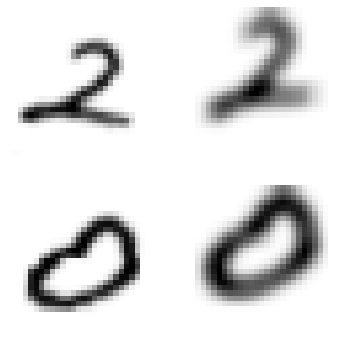

In [8]:
#In this cell we display the augmentations used. 
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=1)
model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=False)
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=2)